# 오버워치 2 점수판 분석 AI

In [1]:
import os
import pandas as pd


def prepare_scoreboard(defeat_, draw_, victory_):
    scoreboard_ = pd.concat([defeat_, draw_, victory_])
    scoreboard_.set_index(pd.Index((i, j) for i in range(len(scoreboard_) // 10) for j in range(10)), inplace=True)
    return scoreboard_


datapath = os.path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
draw = pd.read_csv(datapath + 'draw.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboard = prepare_scoreboard(defeat, draw, victory)
scoreboard

E   A   D   DMG      H   MIT    GAME
0   0   7   3   6  5933   1068  6199  DEFEAT
    1   7   0  10  3601    747     0  DEFEAT
    2   9   1   6  4352      0     0  DEFEAT
    3   7   7   2  2332   6325     0  DEFEAT
    4   6   4   2  3410   5979   606  DEFEAT
...    ..  ..  ..   ...    ...   ...     ...
214 5  11   4  11  6977    645  6378  DEFEAT
    6  10   0  13  7389      0   592  DEFEAT
    7  15   0  13  9338   1985   556  DEFEAT
    8   8  14   8  2859  10260   291  DEFEAT
    9   1  14  10   158  12357     0  DEFEAT

[2150 rows x 7 columns]

In [2]:
scoreboard.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2150 entries, (0, 0) to (214, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       2150 non-null   int64 
 1   A       2150 non-null   int64 
 2   D       2150 non-null   int64 
 3   DMG     2150 non-null   int64 
 4   H       2150 non-null   int64 
 5   MIT     2150 non-null   int64 
 6   GAME    2150 non-null   object
dtypes: int64(6), object(1)
memory usage: 134.1+ KB


In [3]:
scoreboard['GAME'].value_counts()

GAME
DEFEAT     1050
VICTORY    1050
DRAW         50
Name: count, dtype: int64

In [4]:
scoreboard.describe()

,E,A,D,DMG,H,MIT
count,2150.000000,2150.000000,2150.000000,2150.000000,2150.000000,2150.000000
mean,14.041860,7.497674,6.431628,6334.816744,3925.688837,2342.939070
std,10.270022,8.740387,3.882371,4654.797376,5211.986104,4719.817848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2723.250000,0.000000,0.000000
50%,13.000000,4.000000,6.000000,5440.500000,829.000000,249.000000
75%,20.000000,12.000000,9.000000,9360.500000,7557.500000,1772.750000
max,56.000000,48.000000,21.000000,29354.000000,27756.000000,41092.000000


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = os.path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [6]:
tank = scoreboard[::10]
damage = pd.concat([scoreboard[1::10], scoreboard[2::10]])
support = pd.concat([scoreboard[3::10], scoreboard[4::10]])

그림 저장: tank_hist


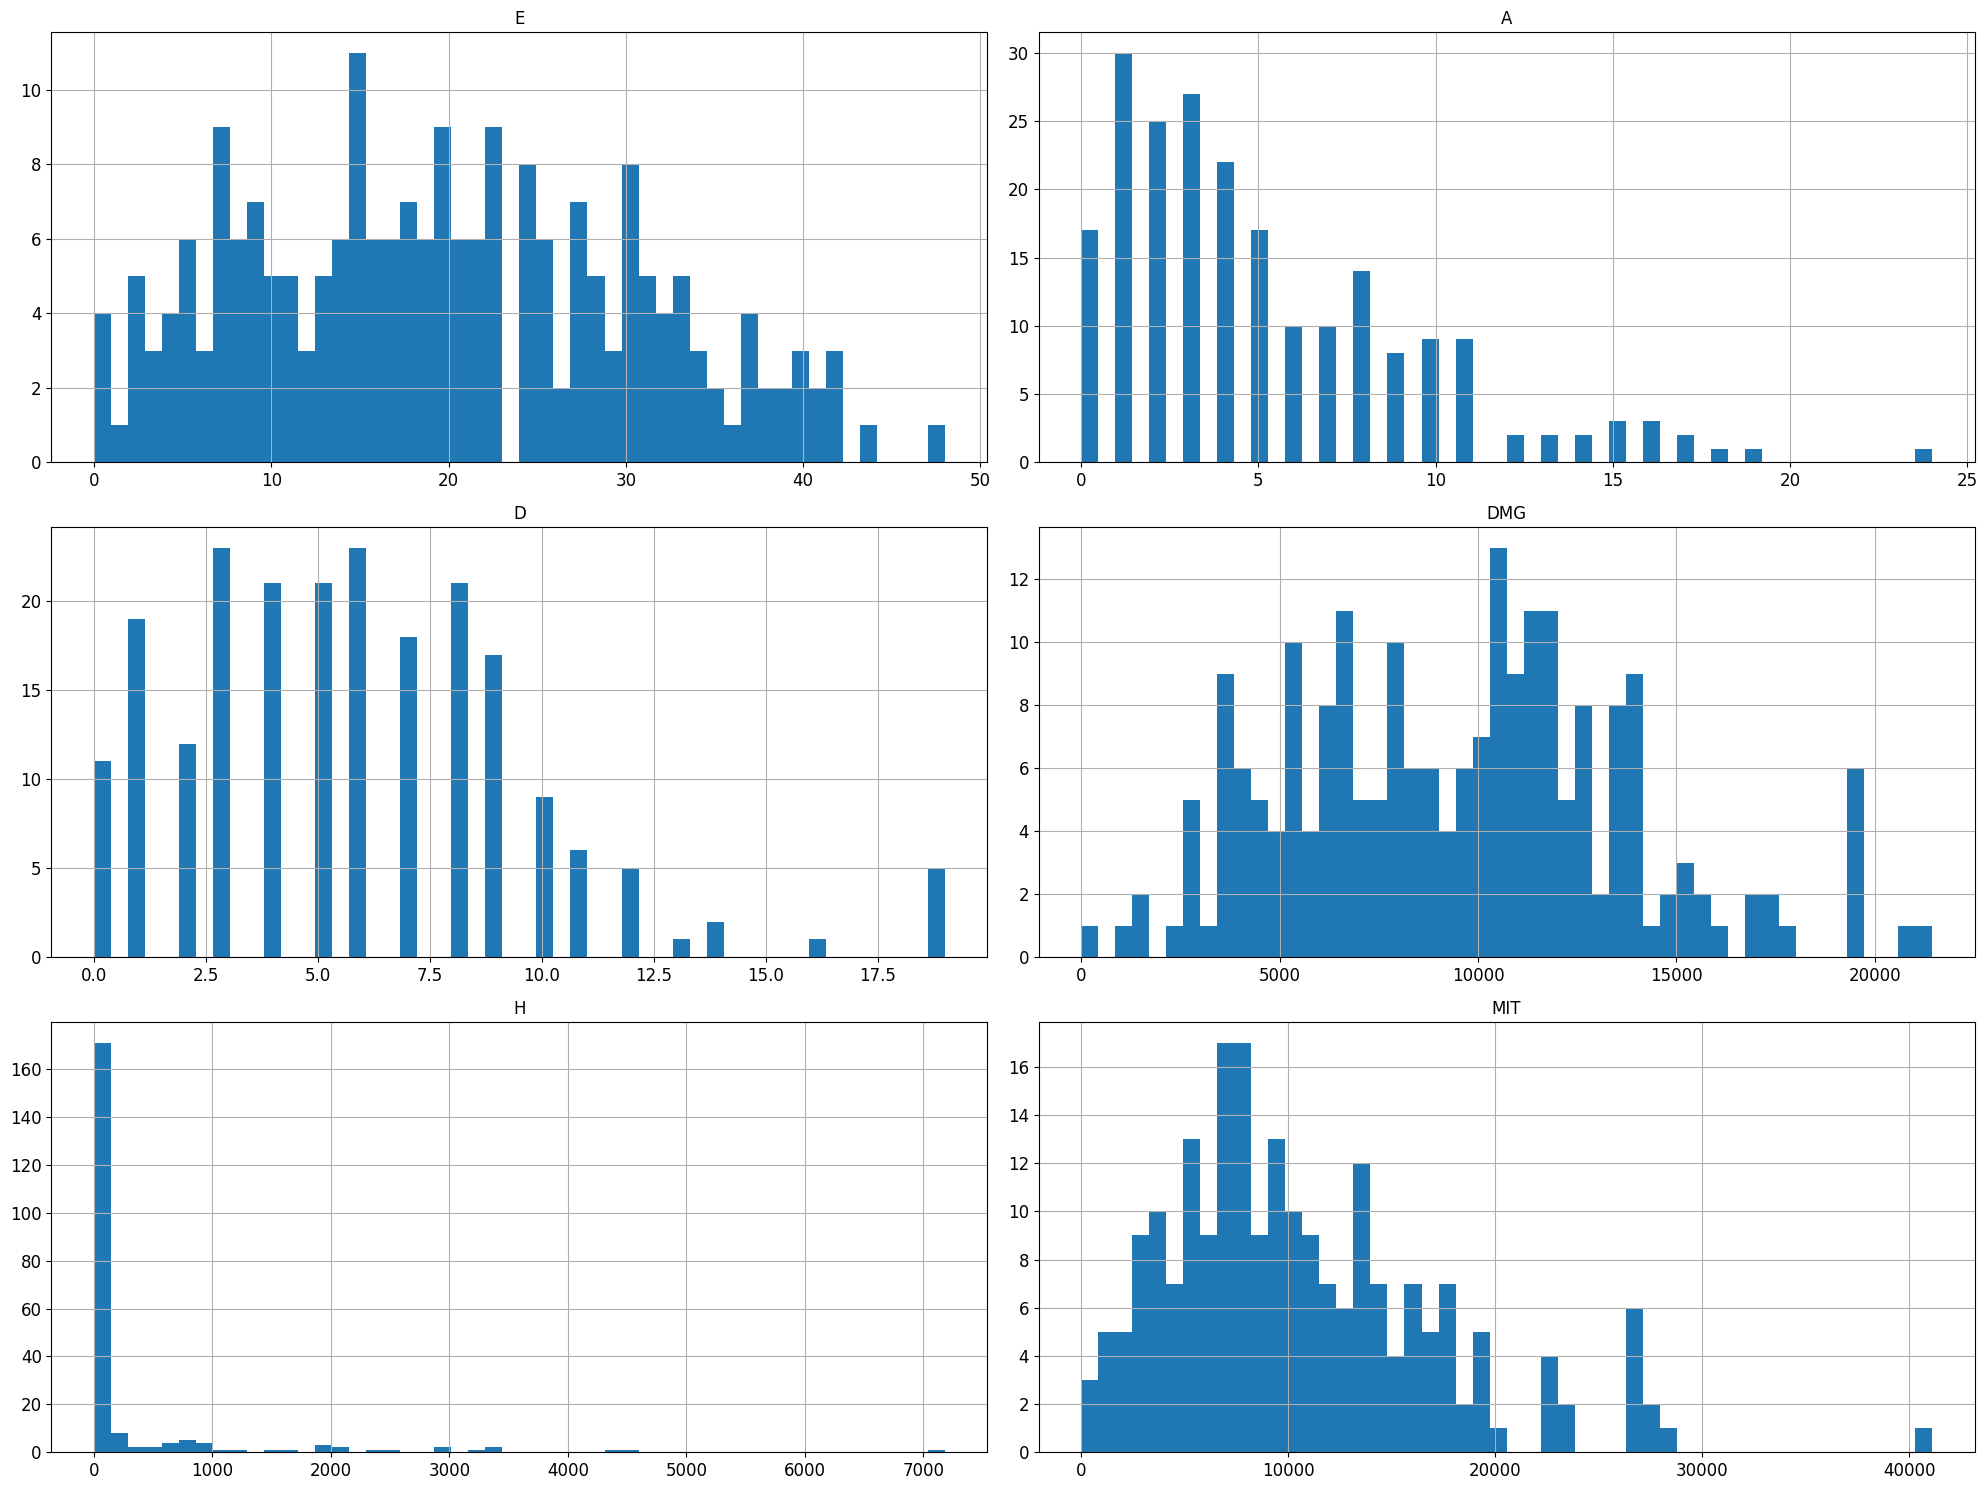

In [7]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장: damage_hist


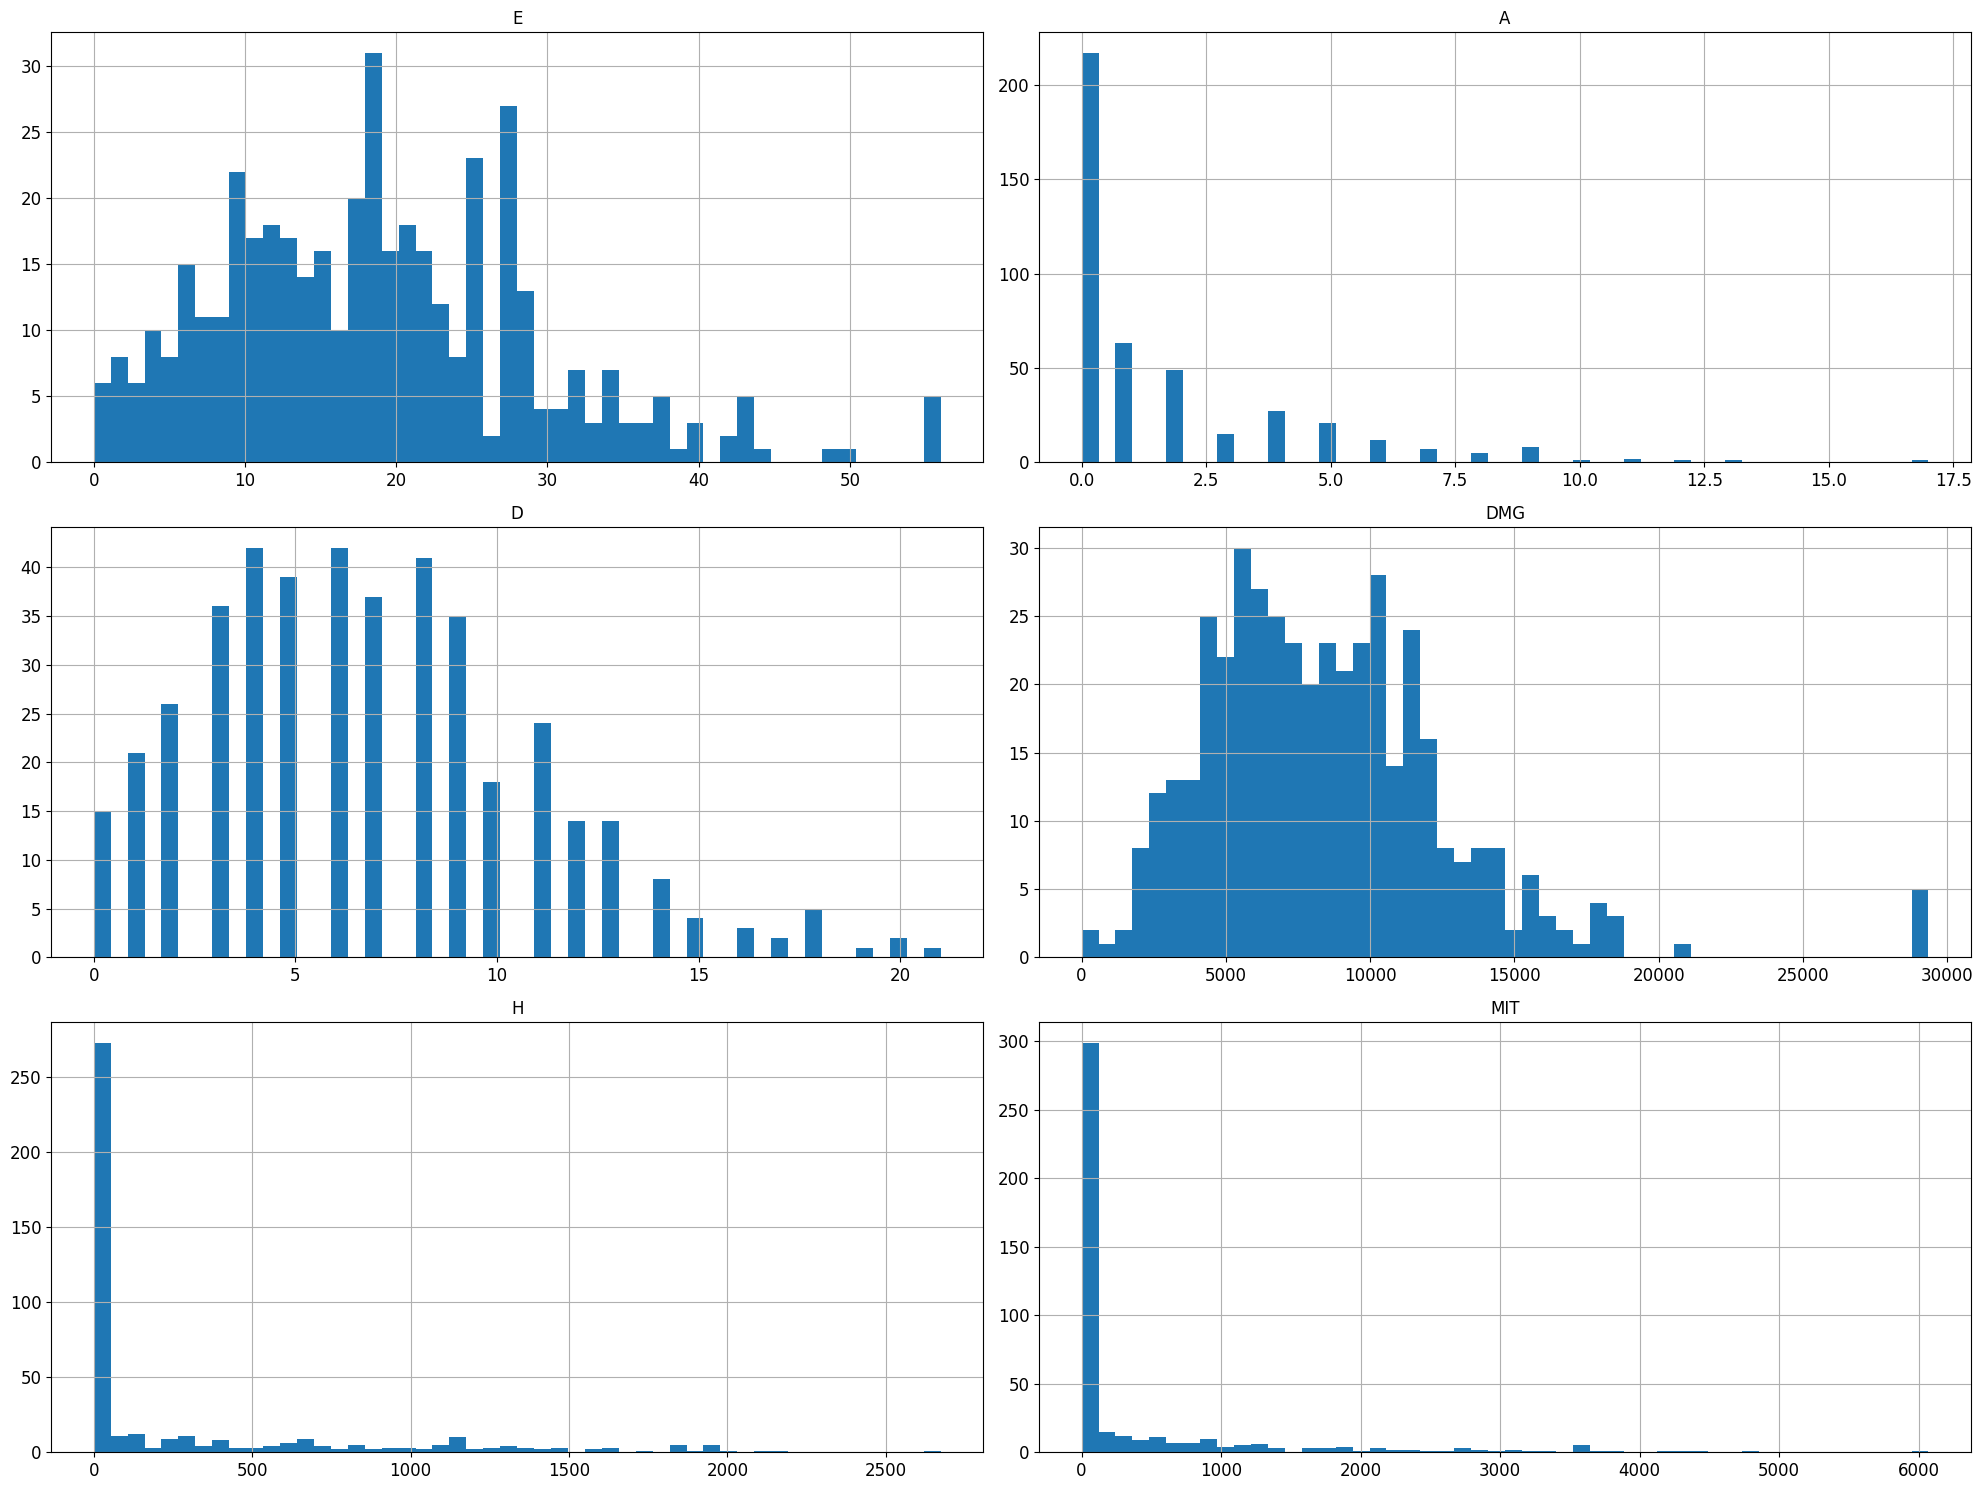

In [8]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장: support_hist


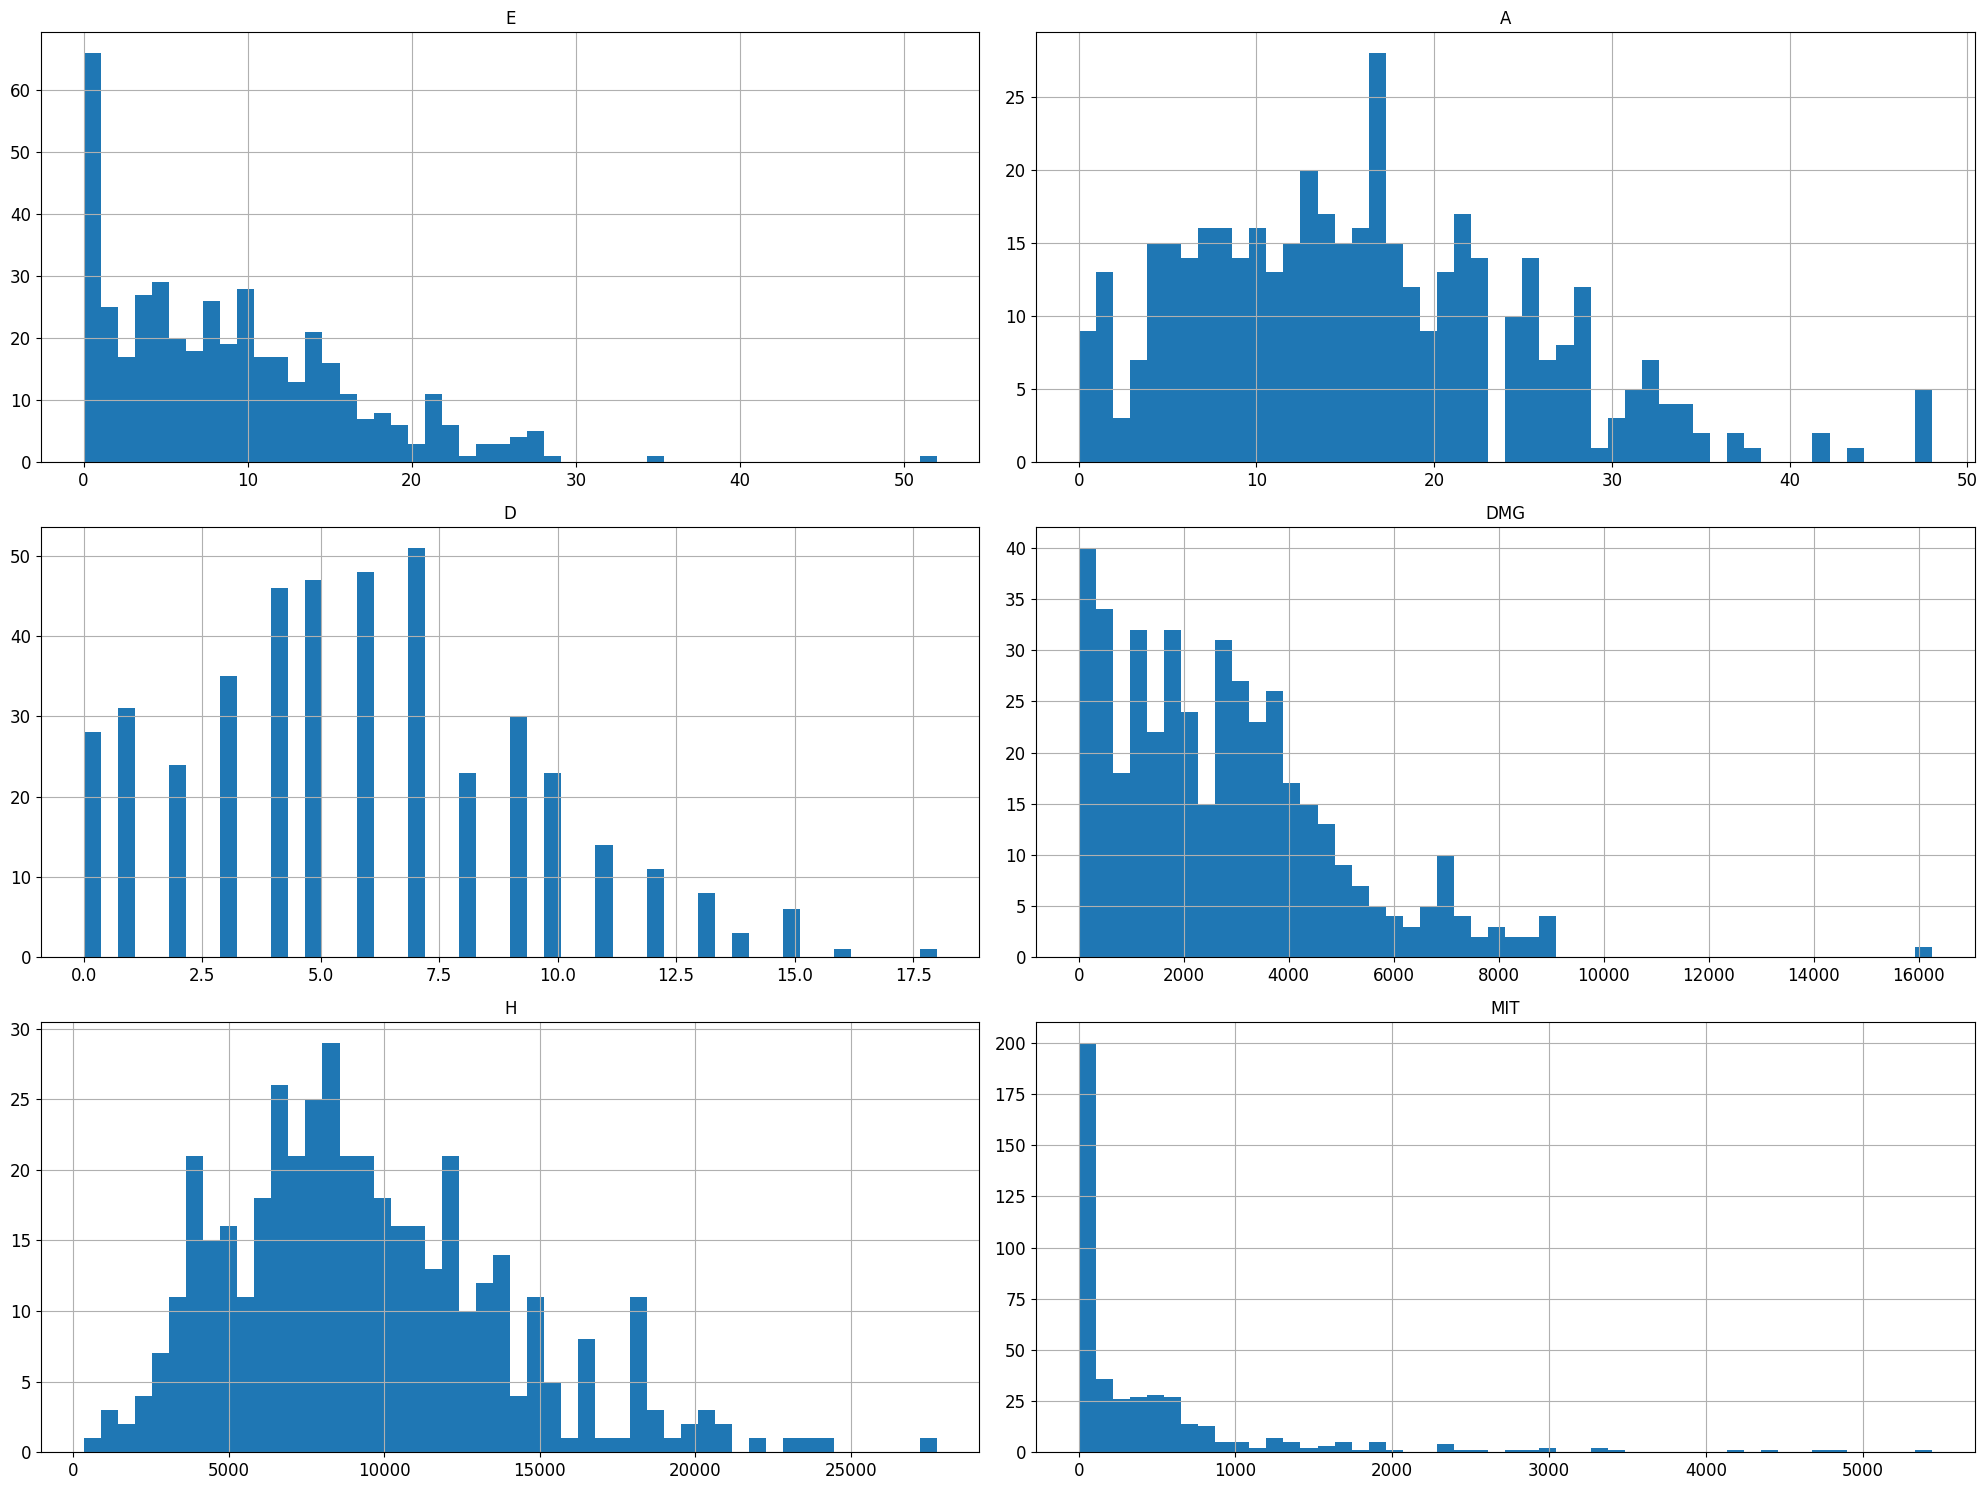

In [9]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [10]:
import numpy as np

train_set = scoreboard.loc[np.random.default_rng().permutation(len(scoreboard) // 10)]

In [11]:
scoreboard = train_set.copy()
# e, a, d, dmg = scoreboard['E'].copy(), scoreboard['A'].copy(), scoreboard['D'].copy(), scoreboard['DMG'].copy()
# e[e == 0], a[a == 0], d[d == 0], dmg[dmg == 0] = .5, .5, .5, .5
# scoreboard['E_per_D'] = e / d
# scoreboard['E_per_DMG'] = e / dmg
# scoreboard['A_per_D'] = a / d
# scoreboard['D_per_DMG'] = d / dmg
# scoreboard.describe()

In [12]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
scoreboard_cat = train_set[['GAME']]
scoreboard_cat_encoded = ordinal_encoder.fit_transform(scoreboard_cat)
scoreboard_cat_encoded[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]])

In [13]:
ordinal_encoder.categories_

[array(['DEFEAT', 'DRAW', 'VICTORY'], dtype=object)]

In [14]:
# from sklearn.base import BaseEstimator, TransformerMixin

# e_ix, a_ix, d_ix, dmg_ix = [scoreboard.columns.get_loc(c) for c in ('E', 'A', 'D', 'DMG')]


# class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.to_numpy(np.float64)
#         e, a, d, dmg = X[:, e_ix], X[:, a_ix], X[:, d_ix], X[:, dmg_ix]
#         e[e == 0], a[a == 0], d[d == 0], dmg[dmg == 0] = .5, .5, .5, .5
#         return np.c_[X, e / d, e / dmg, a / d, d / dmg]


scoreboard_num = train_set.drop('GAME', axis=1)
# attr_adder = CombinedAttributesAdder()
# scoreboard_extra_attribs = attr_adder.transform(scoreboard_num)
# scoreboard_extra_attribs = pd.DataFrame(
#     scoreboard_extra_attribs, scoreboard_num.index, list(scoreboard_num) + ['E_per_D', 'E_per_DMG', 'A_per_D', 'D_per_DMG']
# )
# scoreboard_extra_attribs

In [15]:
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# num_pipeline = Pipeline([('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler())])
# scoreboard_num_tr = num_pipeline.fit_transform(scoreboard_num)
# scoreboard_num_tr

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

full_pipeline = ColumnTransformer(
    # [('num', num_pipeline, scoreboard_num.columns), ('cat', OrdinalEncoder(), scoreboard_cat.columns)]
    [('num', StandardScaler(), scoreboard_num.columns), ('cat', OrdinalEncoder(), scoreboard_cat.columns)]
)
scoreboard_prepared = full_pipeline.fit_transform(train_set)
X = scoreboard_prepared[:, :-1]
shape_ = X.shape[-1]
X = X.reshape(-1, shape_ * 10)
y = scoreboard_prepared[::10, -1]

In [17]:
X

array([[ 0.58028363, -0.17139091,  1.43460483, ..., -0.38911211,
         2.30969746, -0.49652004],
       [-0.00407693, -0.62914301,  0.40406678, ..., -0.86679502,
         0.62683802, -0.4564668 ],
       [-0.10147036, -0.62914301,  0.14643227, ..., -0.29348957,
         0.44318008, -0.47956629],
       ...,
       [-0.19886379, -0.05695288, -0.88410578, ..., -1.2847407 ,
         0.27641022, -0.49652004],
       [-0.88061778, -0.74358104, -0.11120225, ..., -0.79674345,
         0.30039898, -0.40624132],
       [ 2.6255456 ,  0.85855134,  0.66170129, ..., -0.63020982,
         2.11932266, -0.27972396]])

In [18]:
X.shape

(215, 60)

In [19]:
y

array([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 0., 2., 0.,
       2., 0., 2., 2., 2., 2., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 0., 0., 0., 2., 0.,
       0., 2., 2., 2., 2., 0., 0., 0., 2., 2., 0., 0., 2., 2., 2., 2., 2.,
       0., 0., 0., 2., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0., 2., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 2., 2., 0., 2., 2.,
       2., 2., 0., 0., 2., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 2., 2.,
       2., 2., 2., 0., 0., 0., 2., 2., 2., 2., 0., 2., 2., 2., 0., 0., 0.,
       0., 0., 2., 2., 2., 2., 0., 0., 2., 1., 2., 2., 0., 0., 2., 0., 2.,
       0., 0., 2., 2., 0., 2., 0., 0., 0., 0., 2., 0., 2., 2., 0., 0., 0.,
       0., 2., 0., 0., 2., 0., 2., 2., 2., 2., 2., 0., 0., 2., 0., 2., 2.,
       0., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 0., 0., 1.,
       2., 0., 1., 2., 0., 0., 0., 0., 2., 0., 2.])

In [20]:
y.shape

(215,)

In [21]:
from sklearn import ensemble, linear_model, neighbors, svm, tree
from sklearn.model_selection import cross_val_score

models = {
    'AdaBoostClassifier': ensemble.AdaBoostClassifier(),
    'BaggingClassifier': ensemble.BaggingClassifier(n_jobs=-1),
    'ExtraTreesClassifier': ensemble.ExtraTreesClassifier(n_jobs=-1),
    'GradientBoostingClassifier': ensemble.GradientBoostingClassifier(),
    'RandomForestClassifier': ensemble.RandomForestClassifier(n_jobs=-1),
    'HistGradientBoostingClassifier': ensemble.HistGradientBoostingClassifier(),
    'LogisticRegression': linear_model.LogisticRegression(max_iter=300, n_jobs=-1),
    'PassiveAggressiveClassifier': linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    'Perceptron': linear_model.Perceptron(n_jobs=-1),
    'RidgeClassifier': linear_model.RidgeClassifier(),
    'SGDClassifier': linear_model.SGDClassifier(n_jobs=-1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_jobs=-1),
    'RadiusNeighborsClassifier': neighbors.RadiusNeighborsClassifier(19., n_jobs=-1),
    'NearestCentroid': neighbors.NearestCentroid(),
    'LinearSVC': svm.LinearSVC(dual='auto'),
    'NuSVC': svm.NuSVC(nu=.08),
    'SVC': svm.SVC(),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'ExtraTreeClassifier': tree.ExtraTreeClassifier()
}
scores = {}
for k, v in models.items():
    scores[k] = cross_val_score(v, X, y, n_jobs=-1).mean()
sorted_ = sorted(scores.items(), key=lambda item: item[1], reverse=True)
sorted_

[('LogisticRegression', 0.9255813953488371),
 ('SVC', 0.9069767441860466),
 ('RandomForestClassifier', 0.8976744186046511),
 ('ExtraTreesClassifier', 0.8930232558139535),
 ('PassiveAggressiveClassifier', 0.8930232558139535),
 ('RidgeClassifier', 0.8930232558139535),
 ('LinearSVC', 0.8883720930232558),
 ('NuSVC', 0.8883720930232558),
 ('GradientBoostingClassifier', 0.8790697674418604),
 ('HistGradientBoostingClassifier', 0.8790697674418604),
 ('BaggingClassifier', 0.8697674418604651),
 ('SGDClassifier', 0.8697674418604651),
 ('NearestCentroid', 0.8604651162790699),
 ('KNeighborsClassifier', 0.8558139534883722),
 ('Perceptron', 0.841860465116279),
 ('DecisionTreeClassifier', 0.7906976744186046),
 ('ExtraTreeClassifier', 0.7348837209302326),
 ('AdaBoostClassifier', 0.6511627906976745),
 ('RadiusNeighborsClassifier', 0.49767441860465117)]

In [22]:
scoreboard[:]

E   A   D    DMG      H    MIT    GAME
95  0  20   6  12  13989   1872   7796  DEFEAT
    1  25   0   4   9595      0      0  DEFEAT
    2   9   2   6   5368   1143      0  DEFEAT
    3  10  20   9   3120  16355    767  DEFEAT
    4   8  15  11   5374  13686   1424  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
182 5  21   3   9  13612   1477  13299  DEFEAT
    6  19   0  15  11064    272     84  DEFEAT
    7  22   2  11  13069      0    911  DEFEAT
    8  16  23  10   6779  11624    285  DEFEAT
    9   6  20   9   3402  14969   1023  DEFEAT

[2150 rows x 7 columns]

In [23]:
from sklearn.model_selection import cross_val_predict

transform = full_pipeline.named_transformers_.cat.inverse_transform
model = models[sorted_[0][0]]
for i, (y_true, y_pred) in enumerate(
        zip(transform(y.reshape(-1, 1)), transform(cross_val_predict(model, X, y, n_jobs=-1).reshape(-1, 1)))
):
    y_true, y_pred = y_true[0], y_pred[0]
    if y_true != y_pred:
        i = scoreboard.iloc[i * 10].name[0]
        defeats = len(defeat) // 10
        total = defeats + len(draw) // 10
        next_ = i + 1
        if i < defeats:
            print(f'{y_true} ({next_}) -> {y_pred} ({i})')
        elif i < total:
            print(f'{y_true} ({next_ - defeats}) -> {y_pred} ({i})')
        else:
            print(f'{y_true} ({next_ - total}) -> {y_pred} ({i})')
        print(scoreboard.loc[i], end='\n\n')

DEFEAT (14) -> VICTORY (13)
    E   A  D    DMG      H   MIT     GAME
0  27  13  2  12097      0  7906   DEFEAT
1  20   6  6   4732    614   658   DEFEAT
2  15   0  6   9738    269   197   DEFEAT
3  21  21  5   5162   6634     0   DEFEAT
4   9  19  6   1813  11730   853   DEFEAT
5   6   0  5   3895     21  8922  VICTORY
6  13   0  9   9841    670     0  VICTORY
7  20   2  6  10020      0     0  VICTORY
8   2  16  6    783  12379     0  VICTORY
9   9  10  6   4016  10344  4666  VICTORY

DEFEAT (20) -> VICTORY (19)
    E   A   D    DMG      H    MIT     GAME
0  30   6   6  11403      0  16452   DEFEAT
1  20   3   8   6221    840      0   DEFEAT
2  31   0  10  15196      0    208   DEFEAT
3   5  27   9   2617  12801      0   DEFEAT
4  14  23   8   3678  15469    537   DEFEAT
5  19   4  10  12751      0  11415  VICTORY
6  20   1  10  11706   1483      0  VICTORY
7  22   1  13  10877    285   6265  VICTORY
8  12  15   8   5251  10988   2441  VICTORY
9   6  14   7   3713   7995     22  VICTO

In [24]:
for model, _ in sorted_:
    model = models[model].fit(X, y)
    if hasattr(model, 'feature_importances_'):
        print(model)
        importances = model.feature_importances_.reshape(-1, shape_)

        tank = importances[[0, 5]]
        damage = importances[[1, 2, 6, 7]]
        support = importances[[3, 4, 8, 9]]

        feature = '돌격 1인', '공격 1인', '지원 1인'

        print('\n**역할 중요도**')
        sum_ = tank.sum(), damage.sum() / 2, support.sum() / 2
        for s, f in sorted(zip(sum_, feature), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        feature = '처치', '도움', '죽음', '피해', '치유', '경감'  # , '죽음당 처치', '피해당 처치', '죽음당 도움', '피해당 죽음'

        print('\n**특성 중요도**')
        for s, f in sorted(zip(importances.sum(0), feature), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        print('\n**돌격 1인 특성 중요도**')
        for s, f in sorted(zip(tank.sum(0), feature), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        print('\n**공격 1인 특성 중요도**')
        for s, f in sorted(zip(damage.sum(0) / 2, feature), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        print('\n**지원 1인 특성 중요도**')
        for s, f in sorted(zip(support.sum(0) / 2, feature), reverse=True):
            print(f'{f}: {s * 100:.0f}%')

        break

RandomForestClassifier(n_jobs=-1)

**역할 중요도**
돌격 1인: 30%
지원 1인: 18%
공격 1인: 17%

**특성 중요도**
처치: 33%
죽음: 23%
도움: 20%
피해: 11%
치유: 7%
경감: 5%

**돌격 1인 특성 중요도**
처치: 12%
죽음: 8%
도움: 5%
피해: 3%
경감: 2%
치유: 1%

**공격 1인 특성 중요도**
처치: 8%
죽음: 4%
피해: 3%
치유: 1%
도움: 1%
경감: 1%

**지원 1인 특성 중요도**
도움: 7%
죽음: 4%
처치: 3%
치유: 2%
피해: 2%
경감: 1%
